In [1]:
from pytrends.request import TrendReq
import pandas as pd
import re
import matplotlib.pyplot as plt
import scipy.stats as sci
import numpy as np
import time
df = pd.read_csv('symptoms.csv', sep=',',encoding='latin-1')


In [3]:
#Test call to see whether I am still blocked by Google,lol
pytrend = TrendReq()

test = 'Husten'
pytrend.build_payload(kw_list=['{}'.format(test)],geo="DE",timeframe='today 5-y',cat=0)
google_trend_per_syndrom = pytrend.interest_over_time()
google_values_unnormlised = google_trend_per_syndrom['{}'.format(test)].values
google_values= google_values_unnormlised/max(google_values_unnormlised)+0.0000001
print(google_values)


[0.7000001 0.5600001 0.5300001 0.4700001 0.4400001 0.4500001 0.4000001
 0.3700001 0.3500001 0.3800001 0.4100001 0.3800001 0.2900001 0.3300001
 0.3000001 0.2700001 0.2800001 0.2500001 0.2700001 0.2800001 0.2500001
 0.2200001 0.1900001 0.1900001 0.1900001 0.1800001 0.2300001 0.2200001
 0.2300001 0.2600001 0.3100001 0.3400001 0.4100001 0.4300001 0.4000001
 0.4400001 0.3900001 0.3700001 0.3800001 0.3900001 0.3700001 0.4000001
 0.3800001 0.3700001 0.4800001 0.4300001 0.3700001 0.3400001 0.3500001
 0.4300001 0.4600001 0.4500001 0.5100001 0.5000001 0.5700001 0.5000001
 0.5200001 0.4400001 0.4400001 0.4100001 0.4200001 0.3600001 0.3200001
 0.2800001 0.2800001 0.3500001 0.3600001 0.2900001 0.3200001 0.2600001
 0.2600001 0.2500001 0.2400001 0.2800001 0.2600001 0.2600001 0.2200001
 0.2300001 0.2400001 0.2500001 0.2900001 0.3000001 0.2800001 0.3400001
 0.4100001 0.4000001 0.4800001 0.4700001 0.4700001 0.4800001 0.4500001
 0.4800001 0.4900001 0.5200001 0.5700001 0.6200001 0.6500001 0.7000001
 0.590

In [4]:
#If there are words in brackets and they start with a capital letter, keep and discard the rest
def word_in_bracket(x):
    match = re.search(r'.+?\(([A-Z].+)\)',x)
    if match is not None:
        return match.group(1)
    else:
        return x
    

In [5]:
#Cleaning of the data, as in the preprocessings scripts
df = pd.read_csv('symptoms.csv', sep=',',encoding='latin-1')
df.reset_index(drop=True)
df = df.drop(columns=['Unnamed: 0','[PathogenMitKrankheit].[Meldeweg Web71].[Meldeweg ID Web71].[MEMBER_CAPTION]'])
df = df.rename(columns={'[PathogenMitKrankheit].[Meldeweg Web71].[Krankheit ID Web71].[MEMBER_CAPTION]': 'Krankheit', '[Symptome].[ID].[ID].[MEMBER_CAPTION]': 'Symptom', '[ReportingDate].[YearWeek].[YearWeek].[MEMBER_CAPTION]': 'Kalenderwoche', '[Measures].[FallCount]': 'Anzahl'}) 


df_selection = df.drop(columns='Krankheit')
df_selection['Symptom'] = df_selection['Symptom'].apply(lambda x: 'Durchfall' if x =="Durchfall und/oder Erbrechen" else x)
df_selection['Symptom'] = df_selection['Symptom'].apply(lambda x: 'Durchfall' if x =="Durchfall, nicht näher bezeichnet" else x)
df_selection['Symptom'] = df_selection['Symptom'].apply(lambda x: 'Muskel-, Glieder-, Rücken- oder Kopfschmerzen' if x =="Gliederschmerzen" else x)
df_selection['Symptom'] = df_selection['Symptom'].apply(lambda x: 'Hirnhautentzündung' if x.startswith("Meningitis") else x)
df_selection['Symptom'] = df_selection['Symptom'].apply(word_in_bracket)


df_selection_pivot = df_selection.groupby(['Symptom','Kalenderwoche'])['Anzahl'].sum().reset_index()
df_selection_pivot.sort_values('Kalenderwoche')
df_selection_all_symptoms = df_selection.groupby(['Symptom'])['Anzahl'].sum().reset_index()['Symptom'].tolist()



new_rows = []
for week in df['Kalenderwoche'].drop_duplicates().sort_values():
    for symptom in df_selection_all_symptoms:
        sample_week = df_selection_pivot[df_selection_pivot['Kalenderwoche'] == week]
        if not sample_week.isin({'Symptom': [symptom]})['Symptom'].any():
            new_row = [symptom, week, 0]
            new_rows.append(new_row)
            
            
new_values = pd.DataFrame(new_rows, columns=['Symptom','Kalenderwoche','Anzahl'])

#append these illnesses with 0 'Anzahl'
df_selection_pivot= df_selection_pivot.append(new_values)
df_weekly_symptoms = df_selection_pivot.sort_values('Kalenderwoche').reset_index(drop=True)
df_weekly_symptoms = df_weekly_symptoms.sort_values(['Kalenderwoche','Symptom'],ascending=[True,True])





In [6]:
#df_weekly_symptoms.to_pickle('df_weekly_symptoms.pkl')

In [6]:
#create a dictonary of dataframes per symptom
dict_symptomps = {}
symptoms = set(df_weekly_symptoms["Symptom"])
symptoms = list(symptoms)
symptoms.sort()
dataframes = [df_weekly_symptoms[df_weekly_symptoms["Symptom"]=='{}'.format(symptom)] for symptom in symptoms]
dict_symptomps = dict(zip(symptoms,dataframes))

In [54]:
#To filter symptoms. Copy symptoms contains the original name and short symp the shortend version

def filter_symptoms(x):
    match = re.search(r'([A-Z]+[^\s]*)\s',x)
    if match:
        return match.group(1)
    
to_be_changed_symptoms = []
for i, symp in enumerate(dict_symptomps):
    to_be_changed_symptoms.append(symp)


filtered_symp = map(filter_symptoms, to_be_changed_symptoms)
filtered_symp = list(filtered_symp)

copy_symptoms = symptoms.copy()

#Save the index where None
index =[]
for i in range(len(filtered_symp)):
    if filtered_symp[i] == None:
        index.append(i)
#Delete where entry is None
for i in range(len(index)):
    del filtered_symp[index[i]]
    del copy_symptoms[index[i]]
    index[:] = [x - 1 for x in index]
    
               



117


In [12]:
#The indices of the remaining symptoms I am interested in merged to a dict

indices = [4,11,12,13,14,16,18,20,21,24,25,26,27,28,36,37,38,39,41,42,46,47,48,49,52,53,67,70,71,76,77,111]
reduced_keys = [copy_symptoms[indices[i]] for i in range(len(indices))]
reduced_short_keys = [filtered_symp[indices[i]] for i in range(len(indices))]

dataframes_for_short = [df_weekly_symptoms[df_weekly_symptoms["Symptom"]=='{}'.format(key)] for key in reduced_keys]
dict_symptomps_shortened = dict(zip(reduced_keys,dataframes_for_short))


In [79]:
rki_values = np.zeros((len(dict_symptomps_shortened),261))
google_values = np.zeros((len(dict_symptomps_shortened),261))
pytrend = TrendReq()

for i, symptom in enumerate(reduced_keys):
    rki_timeseries = dict_symptomps['{}'.format(symptom)]
    rki_timeseries = rki_timeseries[-261:]
    rki_values_unnormlised = rki_timeseries['Anzahl'].values
    if max(rki_values_unnormlised) !=0:
        rki_values[i,:] = rki_values_unnormlised/max(rki_values_unnormlised)
    else:
        rki_values[i,:] = 0
for i, symptom in enumerate(reduced_short_keys):
    try:
        pytrend.build_payload(kw_list=['{}'.format(symptom)],geo="DE",timeframe='today 5-y',cat=0)
        google_trend_per_syndrom = pytrend.interest_over_time()
        google_values_unnormlised = google_trend_per_syndrom['{}'.format(symptom)].values
        if max(rki_values_unnormlised) !=0:
            google_values[i,:] = google_values_unnormlised/max(google_values_unnormlised)
        else:
            google_values[i,:] = 0        
        time.sleep(10)
    except:
        print('exception for',symptom)


exception for Blutstuhl,
exception for Haut-
exception for Haut-,
exception for Hautläsion,
exception for Hautläsion,
exception for Himbeer-
exception for Hirndruckzeichen,
exception for Hirnnervenstörung,
exception for Muskel-,
exception for Muskel-,


In [81]:
correlation_values = np.zeros((len(dict_symptomps_shortened)))
for i in range(len(dict_symptomps_shortened)):
    try:
        output_tuple = sci.pearsonr(google_values[i],rki_values[i])
        correlation_values[i] = output_tuple[0]
    except RuntimeWarning:
        print('shits on fire')

/home/student/a/aabbood/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


In [82]:
correlation_values

array([-0.08232121,  0.3681181 ,  0.44082959, -0.1440823 ,  0.08029795,
               nan, -0.07059416, -0.01349553, -0.00914346, -0.01772373,
        0.11000947, -0.04765825,  0.1713785 ,  0.25243447,         nan,
               nan,  0.01573532, -0.00201633,         nan,         nan,
               nan,         nan,         nan,  0.32178841, -0.13080459,
       -0.06572668,  0.11277094,         nan,         nan, -0.07238027,
       -0.06188982,  0.17688224])

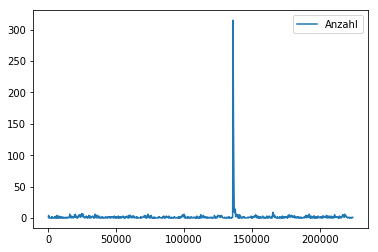

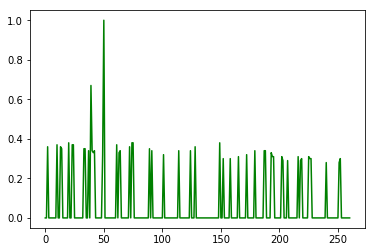

Anämie,


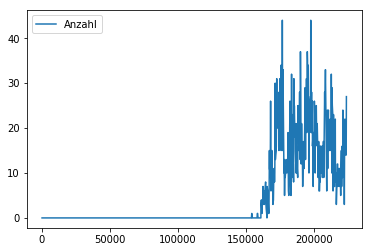

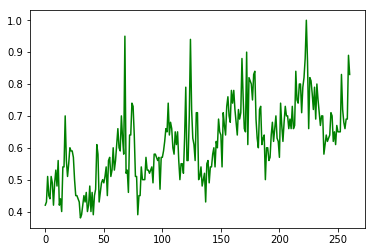

Ausschlag


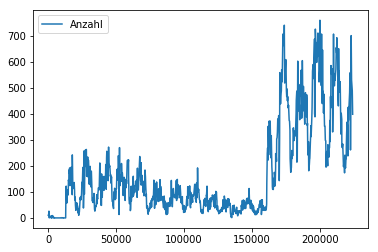

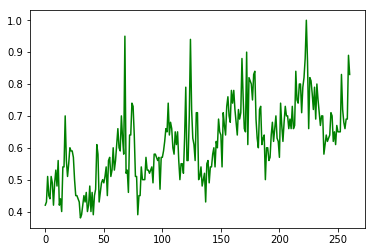

Ausschlag


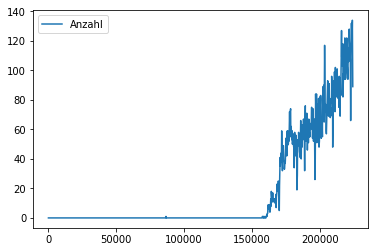

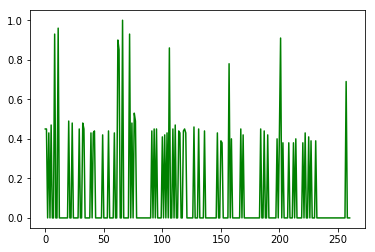

Ausschlag,


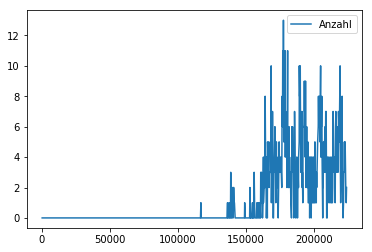

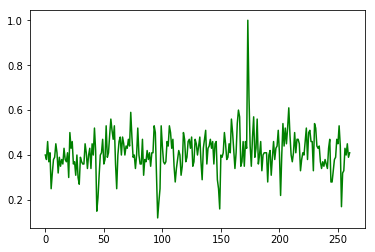

Ausschluss


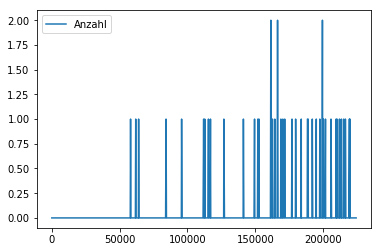

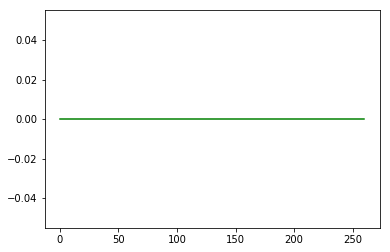

Blutstuhl,


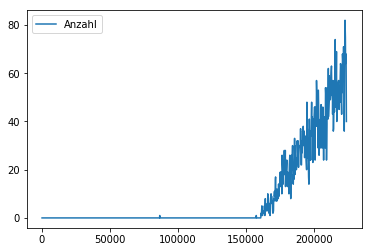

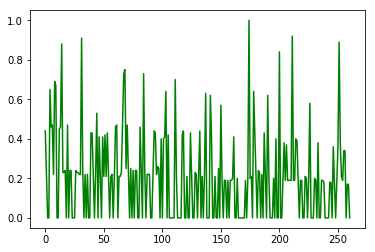

Brennen,


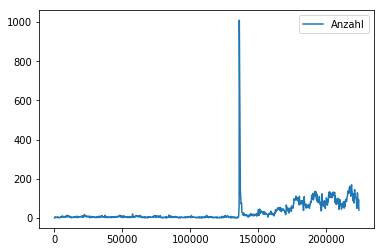

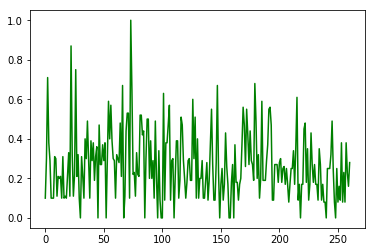

Durchfall,


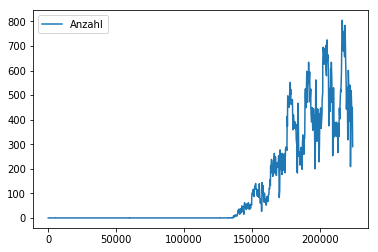

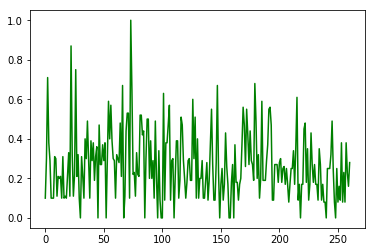

Durchfall,


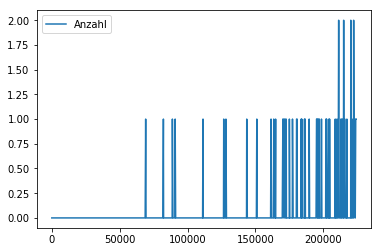

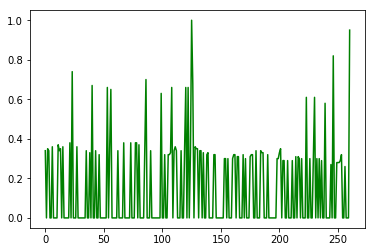

Eiteransammlung


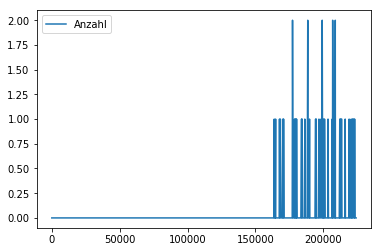

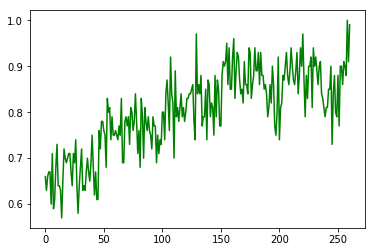

Entzündung


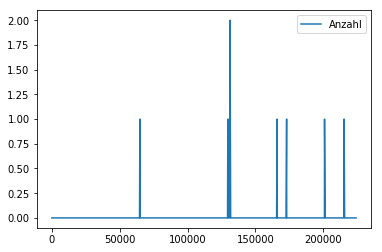

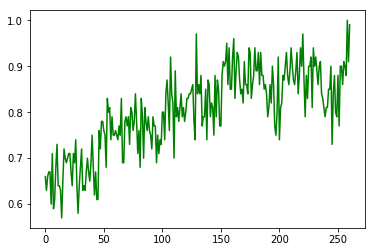

Entzündung


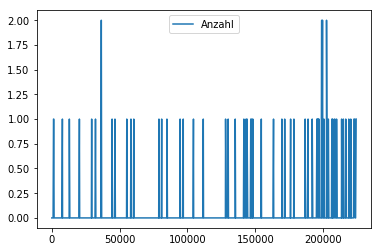

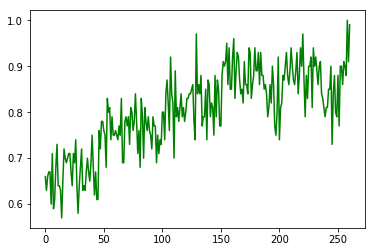

Entzündung


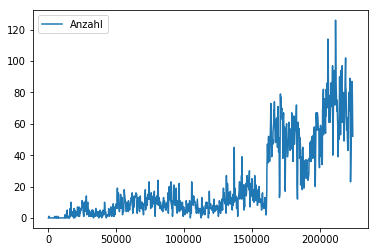

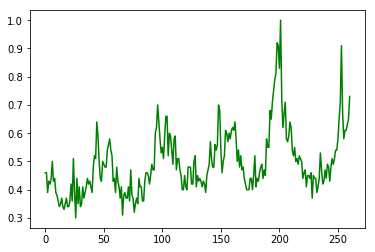

Erbrechen


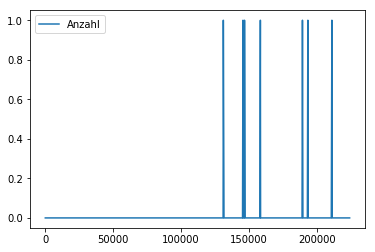

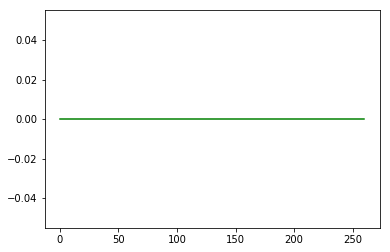

Haut-


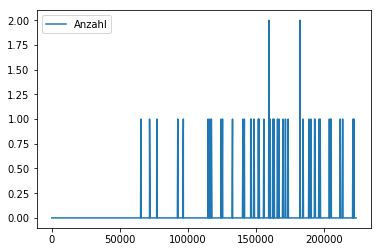

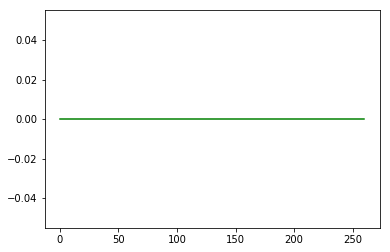

Haut-,


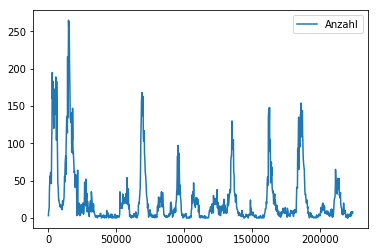

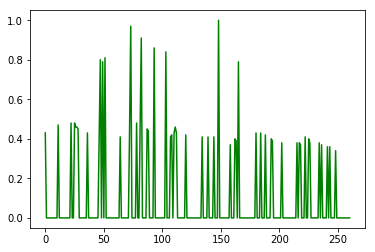

Hautausschlag,


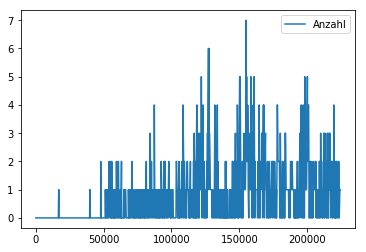

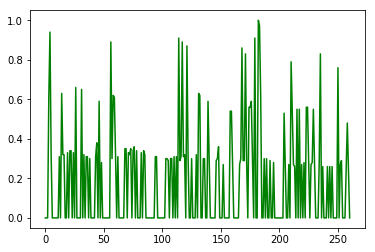

Hauteinblutungen


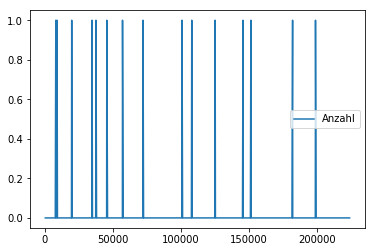

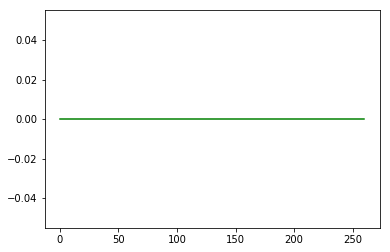

Hautläsion,


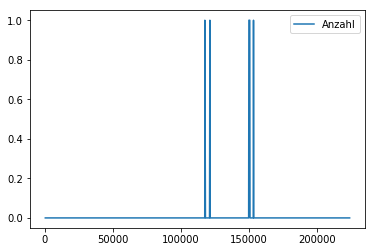

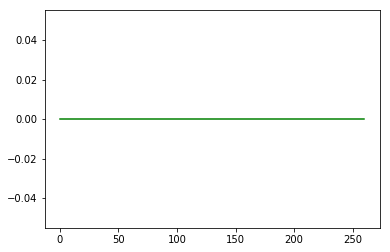

Hautläsion,


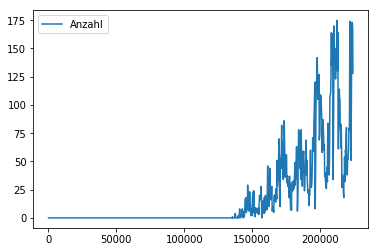

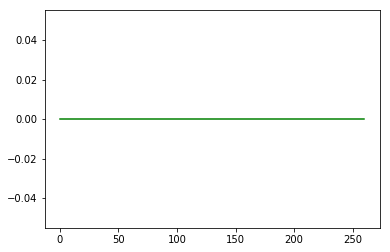

Himbeer-


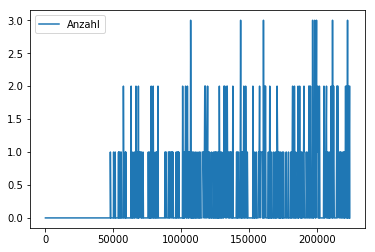

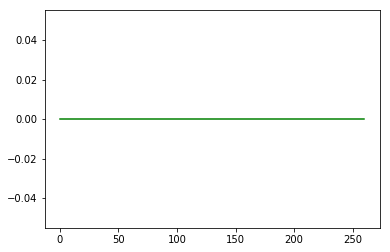

Hirndruckzeichen,


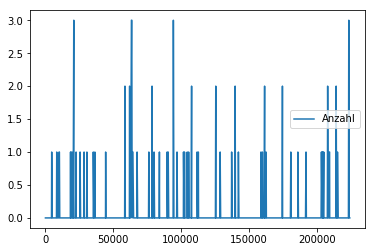

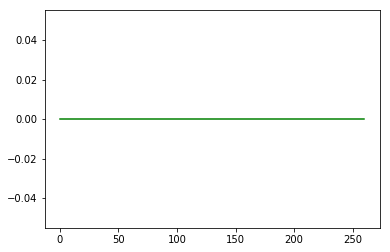

Hirnnervenstörung,


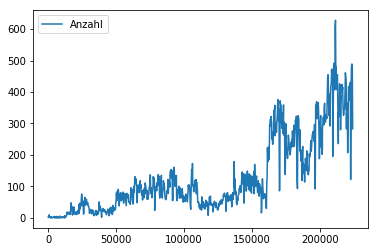

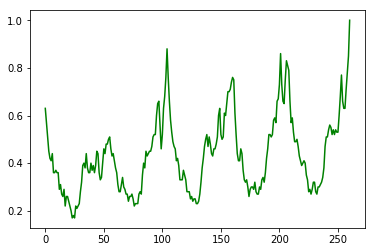

Husten


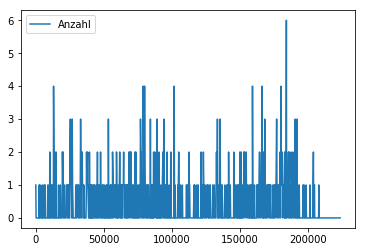

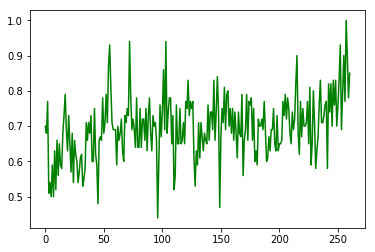

Infektion


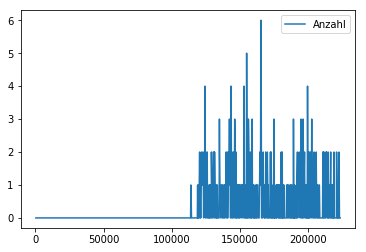

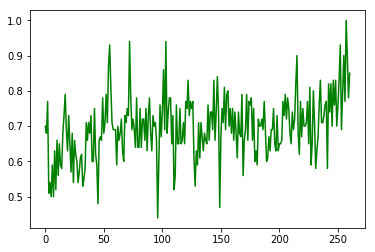

Infektion


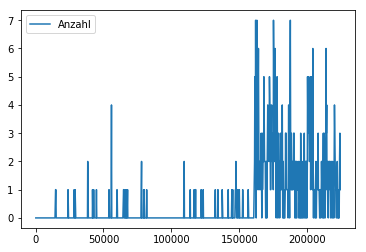

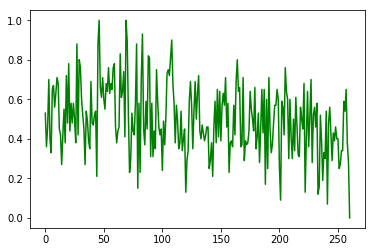

Lymphknotenschwellung


In [ ]:
for i in range(len(reduced_keys)):

    dict_symptomps_shortened[reduced_keys[i]].plot()
    plt.show()
    plt.plot(google_values[i],'g')
    plt.show()
    print(reduced_short_keys[i])
    time.sleep(5)